In [12]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from numpy import array

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn import preprocessing

from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense

# Input data:

In [2]:
# Read csv of Education distribution
# Remove all the entries that don't have "County"
df = pd.read_csv('Data_compiled - Education.csv')
df = df[df['Area name'].str.contains('County')]
df = df.sort_values(by=['State','Area name'],ignore_index=True)

In [3]:
# Add columns of Unemployment and Median HH Income
new_df = pd.read_csv('Unemployed_data_compiled.csv')
new_df = new_df[new_df['Area name'].str.contains('County')]
new_df.sort_values(by=['Area name'],ignore_index=True)

# For this file, area name stick with state => split it
def f(x,delm=','):
    return x.split(delm)[0], x.split(delm)[1][1:]

new_df['State'] = new_df['Area name'].map(lambda x: f(x)[1])
new_df['Area name'] = new_df['Area name'].map(lambda x: f(x)[0])
new_df['Median_Household_Income_2018'] = new_df['Median_Household_Income_2018'].map(lambda x: (f(x)[0]+f(x)[1]))

new_df = new_df.sort_values(by=['State','Area name'],ignore_index=True)
result = pd.merge(df,new_df,how='inner', on=['Area name','State'])
df = result.rename(columns={"Area name": "County", "Unemployment_rate_2019": "Percent of unemployment 2019", 
                       "Median_Household_Income_2018": "Median Household Income 2018"})
df["Median Household Income 2018"] = df["Median Household Income 2018"].astype(float)

In [4]:
name = pd.read_csv('Data_compiled - State - Abbre..csv')
n = name['State.1'].tolist()
# Match up the states with their abbreviation
d = dict(zip(name.State, n))

In [5]:
df1 = pd.read_csv('Population-Density By County - Population-Density By County.csv')
df1 = df1.rename(columns={'GEO.display-label':'State','GCT_STUB.display-label':'County'})
df1 = df1.drop(['GEO.id','GEO.id2','GCT_STUB.target-geo-id','GCT_STUB.target-geo-id2'], axis = 1)
df1 = df1.sort_values(by=['State','County'],ignore_index=True)
df1 = df1.replace(d)
df = pd.merge(df,df1,how='inner', on=['County','State'])

In [6]:
df2 = pd.read_csv('PopulationEstimates.xls - Population Estimates 2010-19.csv')

new_header = df2.iloc[1] #grab the second row for the header
df2 = df2[2:]  #take the data less the header row
df2.columns = new_header  #set the header row as the df header

df2 = df2[df2['Area_Name'].str.contains('County')]
df2.POP_ESTIMATE_2019 = df2.POP_ESTIMATE_2019.str.replace(r'[^\w\s]+', '')
df2["POP_ESTIMATE_2019"] = pd.to_numeric(df2["POP_ESTIMATE_2019"])

df2 = df2[['State','Area_Name','POP_ESTIMATE_2019']]
df2 = df2.rename(columns = {"Area_Name": "County",'POP_ESTIMATE_2019':'POP ESTIMATE 2019'})
df2 = df2.sort_values(by=['State','County'],ignore_index=True)
df = pd.merge(df,df2,how='inner', on=['County','State'])

In [7]:
df3 = pd.read_csv('Data_compiled - Election Result.csv')
df3 = df3.drop(columns = 'Unnamed: 1')
df3 = df3.rename(columns = {'Percent': 'Percentage of Vote for Biden'})
df3.County = [str(County) + ' County' for County in df3.County]
df3 = df3.sort_values(by=['State','County'],ignore_index=True)
df = pd.merge(df,df3,how='inner', on=['County','State'])

In [8]:
df

,State,County,"Percent of adults with less than a high school diploma, 2014-18","Percent of adults with a high school diploma only, 2014-18","Percent of adults completing some college or associates degree, 2014-18","Percent of adults with a bachelors degree or higher, 2014-18",Percent of unemployment 2019,Median Household Income 2018,Density per square mile of land area,POP ESTIMATE 2019,Percentage of Vote for Biden
0,AL,Autauga County,11.3,32.6,28.4,27.7,2.7,5938.0,91.8,55869,0.27
1,AL,Baldwin County,9.7,27.6,31.3,31.3,2.7,5788.0,114.6,223234,0.22
2,AL,Barbour County,27.0,35.7,25.1,12.2,3.8,3482.0,31.0,24686,0.46
3,AL,Bibb County,16.8,47.3,24.4,11.5,3.1,4664.0,36.8,22394,0.21
4,AL,Blount County,19.8,34.0,33.5,12.6,2.7,5012.0,88.9,57826,0.10
...,...,...,...,...,...,...,...,...,...,...,...
2931,WY,Sweetwater County,9.0,33.3,35.7,22.0,3.9,7315.0,4.2,42343,0.23
2932,WY,Teton County,5.6,13.2,23.8,57.4,2.7,9987.0,5.3,23464,0.67
2933,WY,Uinta County,7.2,40.1,37.2,15.4,3.9,6301.0,10.1,20226,0.17
2934,WY,Washakie County,10.4,30.3,37.7,21.5,3.9,5590.0,3.8,7805,0.16


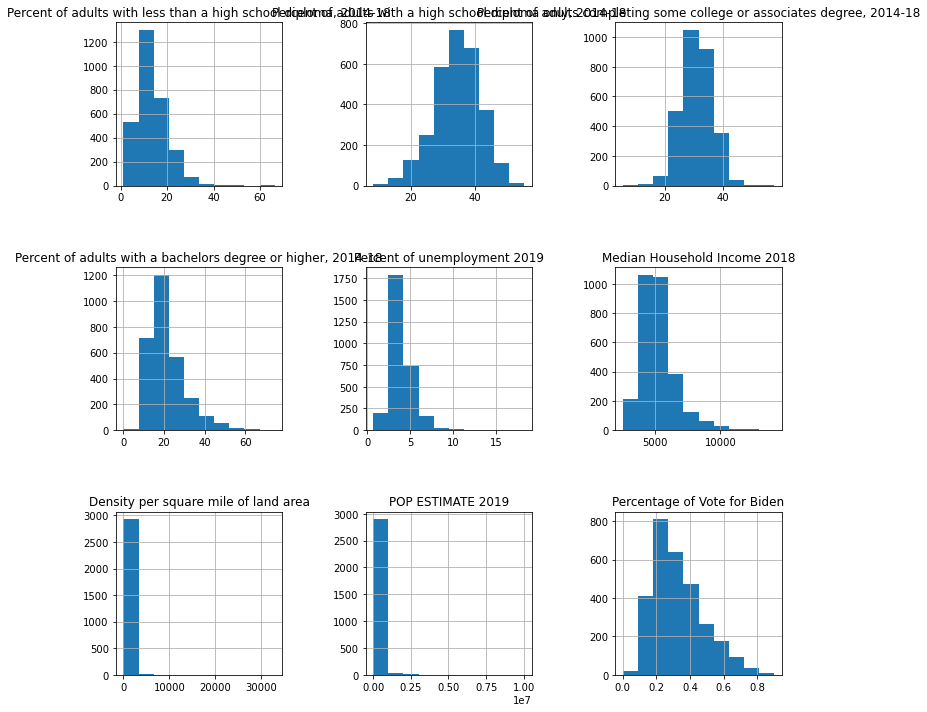

In [9]:
df.hist(figsize=(10, 10))
plt.tight_layout()
plt.subplots_adjust(wspace=0.5, hspace=0.5) 

# Normalize stationary data

In [13]:
df_norm = df.copy()
df_normalized = df_norm.copy()
df_norm = df_norm.drop(columns=['State','County','Percentage of Vote for Biden'])
x = df_norm.values
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
vals = pd.DataFrame(x_scaled)
df_normalized['Percent of adults with less than a high school diploma, 2014-18']=vals[0]
df_normalized['Percent of adults with a high school diploma only, 2014-18']=vals[1]
df_normalized['Percent of adults completing some college or associates degree, 2014-18']=vals[2]
df_normalized['Percent of adults with a bachelors degree or higher, 2014-18']=vals[3]
df_normalized['Percent of unemployment 2019']=vals[4]
df_normalized['Median Household Income 2018']=vals[5]
df_normalized['Density per square mile of land area']=vals[6]
df_normalized['POP ESTIMATE 2019']=vals[7]
df_normalized

,State,County,"Percent of adults with less than a high school diploma, 2014-18","Percent of adults with a high school diploma only, 2014-18","Percent of adults completing some college or associates degree, 2014-18","Percent of adults with a bachelors degree or higher, 2014-18",Percent of unemployment 2019,Median Household Income 2018,Density per square mile of land area,POP ESTIMATE 2019,Percentage of Vote for Biden
0,AL,Autauga County,0.155146,0.515789,0.438835,0.371314,0.113636,0.292380,0.002787,0.005548,0.27
1,AL,Baldwin County,0.130568,0.410526,0.495146,0.419571,0.113636,0.279347,0.003480,0.022220,0.22
2,AL,Barbour County,0.396313,0.581053,0.374757,0.163539,0.176136,0.078982,0.000939,0.002442,0.46
3,AL,Bibb County,0.239631,0.825263,0.361165,0.154155,0.136364,0.181684,0.001115,0.002214,0.21
4,AL,Blount County,0.285714,0.545263,0.537864,0.168901,0.113636,0.211921,0.002699,0.005743,0.10
...,...,...,...,...,...,...,...,...,...,...,...
2931,WY,Sweetwater County,0.119816,0.530526,0.580583,0.294906,0.181818,0.412025,0.000125,0.004201,0.23
2932,WY,Teton County,0.067588,0.107368,0.349515,0.769437,0.113636,0.644192,0.000158,0.002320,0.67
2933,WY,Uinta County,0.092166,0.673684,0.609709,0.206434,0.181818,0.323920,0.000304,0.001998,0.17
2934,WY,Washakie County,0.141321,0.467368,0.619417,0.288204,0.181818,0.262143,0.000112,0.000761,0.16


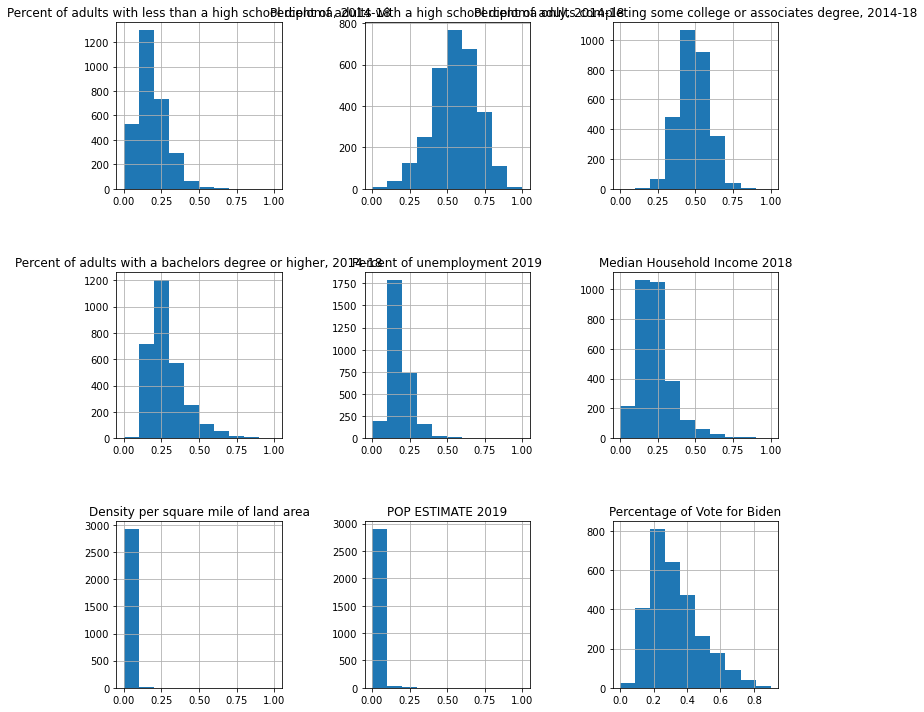

In [14]:
df_normalized.hist(figsize=(10, 10))
plt.tight_layout()
plt.subplots_adjust(wspace=0.5, hspace=0.5) 

In [ ]:
# Add data of covid case
COVID_counties_df=pd.read_csv('us_counties_covid19_daily.csv')
del COVID_counties_df['fips']

# Testing with Baltimore county
COVID_baltimore_df=COVID_counties_df[COVID_counties_df['county']=='Baltimore']
stat_data_baltimore_df=df_norm.loc[df['County'].str.contains('Baltimore')&df['State'].str.contains('MD')]


# Extracting number:
stat_data_baltimore = stat_data_baltimore_df.drop(columns=['County', 'State']).values.tolist()
stat_data_baltimore = np.array(stat_data_baltimore[0])

# Prediction

In [ ]:
# Run the prediction

# split a univariate sequence into samples
def split_sequence(sequence, n_steps, features_data): #features = other data of the county 
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        seq_x = np.append(seq_x,features_data)
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

# Perform prediction 
def single_pred(x_input, n_steps, features_length, n_features):
    x_input = x_input.reshape((1, n_steps+features_length, n_features))
    yhat = model.predict(x_input, verbose=0)
    return yhat

def make_prediction(cases_train, n_steps, features_data, num_pred):
    features_length = len(features_data)
    yhat_array = np.zeros(num_pred)
    for i in range(num_pred):
        if i < len(cases_train)-n_steps:
            x_input = cases_train[i:i+n_steps]
            x_input = np.append(x_input,features_data)
            yhat = single_pred(x_input, n_steps, features_length, n_features)
            yhat_array[i] = yhat
        else:
            x_input = np.append(x_input[1:n_steps],yhat) # create feature from previous prediction
            x_input = np.append(x_input,features_data) # insert stationary feature
            yhat = single_pred(x_input, n_steps, features_length, n_features)
            yhat_array[i] = yhat
    return yhat_array


In [ ]:
# Data:
cases = np.array(COVID_baltimore_df['cases'])
# Split data to train the model: 70:30
test_train_split = 0.7
cases_train = cases[0:int(len(cases)*test_train_split)]
cases_test = cases[int(len(cases)*test_train_split):]

features_data = stat_data_baltimore
features_length = len(features_data)

In [ ]:
# Perform prediction:

# choose a number of time steps (how many days to use for prediction)
n_steps = 3

# split into samples
X, y = split_sequence(cases_train, n_steps,features_data)
# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))

# define model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(n_steps+features_length, n_features)))  # features_length is length of features_data array 
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# fit model
model.fit(X, y, epochs=200, verbose=0)

yhat_array = make_prediction(cases_train, n_steps, stat_data_baltimore,len(cases)-n_steps)
#print(yhat_array)


In [ ]:
fig,ax = plt.subplots(figsize=(8,6),dpi=100)
ax.plot(cases,'o',markersize=2,alpha=0.2,label='observed')
#ax.plot(np.append(cases_train,yhat_array),'or',markersize=2,alpha=0.2,label='predict')
ax.plot([int(len(cases)*test_train_split),int(len(cases)*test_train_split)],[0,25000],'--',label='train-test split')
ax.plot(np.append(cases[0:n_steps+1],yhat_array),'or',markersize=2,alpha=0.2,label='predict')
ax.set_xlabel('days')
ax.set_ylabel('number of cases')
ax.legend()

# Testing performance with different steps

In [ ]:
steps_list = [1,3,7,14,21,30]

fig,ax = plt.subplots(3,2,figsize=(12,15))

# By the way, take a look at these numpy commands: reshape and where
rowcollist = np.arange(1,7)

# 4,3 means 4 rows, 3 columns
rowcollist = rowcollist.reshape(3,2)

for i in range(0,len(rowcollist)):
    row,col = np.where(rowcollist == i+1)
    #print(row[0], col[0])

# Perform prediction:
for i in range(len(steps_list)):
    # choose a number of time steps (how many days to use for prediction)
    n_steps = steps_list[i]

    # split into samples
    X, y = split_sequence(cases_train, n_steps,features_data)
    # reshape from [samples, timesteps] into [samples, timesteps, features]
    n_features = 1
    X = X.reshape((X.shape[0], X.shape[1], n_features))

    # define model
    model = Sequential()
    model.add(LSTM(50, activation='relu', input_shape=(n_steps+features_length, n_features)))  # features_length is length of features_data array 
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')

    # fit model
    model.fit(X, y, epochs=200, verbose=0)

    yhat_array = make_prediction(cases_train, n_steps, stat_data_baltimore,len(cases)-n_steps)
    #print(yhat_array)

    row, col = np.where(rowcollist == i+1)
    ax[row[0]][col[0]].plot(cases,'o',markersize=2,alpha=0.2,label='observed')
    ax[row[0]][col[0]].plot([int(len(cases)*test_train_split),int(len(cases)*test_train_split)],[0,25000],'--',label='train-test split')
    ax[row[0]][col[0]].plot(np.append(cases[0:n_steps+1],yhat_array),'or',markersize=2,alpha=0.2,label='predict')
    ax[row[0]][col[0]].set_xlabel('days')
    ax[row[0]][col[0]].set_ylabel('number of cases')
    ax[row[0]][col[0]].legend()
    ax[row[0]][col[0]].set_title('Steps = ' + str(steps_list[i]))
fig.show

In [ ]:
df
plt.hist(df['Median Household Income 2018'])